# State graph agent for process mining

In den jüngsten Fortschritten der Künstlichen Intelligenz (KI) hat sich die Integration von großen Sprachmodellen (Large Language Models, LLMs) mit vordefinierten Workflows und Zustandsdiagrammen als leistungsstarkes Paradigma zur Automatisierung komplexer Aufgaben herausgestellt (vgl. Wang et al. [(2023)](https://arxiv.org/abs/2305.03722)). Dieses Notebook demonstriert einen innovativen Ansatz, bei dem ein LLM-Agent, ausgestattet mit einer Python-REPL, eigenständig Aufgaben löst, indem er schrittweise durch einen definierten Prozessablauf argumentiert. Die Implementierung basiert auf den Prinzipien des „Plan-and-Solve“- (vgl. LangGraph [(2024)](https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/2)) und „ReAct“-Prompting (vgl. Yao et al. [(2023)](https://arxiv.org/abs/2210.03629)), die es dem Modell ermöglichen, Aufgaben in handhabbare Schritte zu unterteilen und diese effektiv auszuführen.

## Methodik

Der Ansatz nutzt eine Kombination aus dem logischen Denken und Handeln innerhalb des LLMs, wodurch es ihm ermöglicht wird, durch ein Zustandsdiagramm zu navigieren, das die möglichen Übergänge und Ergebnisse der jeweiligen Aufgabe definiert. Durch die Integration einer strukturierten Anleitung in Form eines Flussdiagramms oder Zustandsgraphen generiert das LLM nicht nur Lösungen, sondern auch Erklärungen für seine Vorgehensweise, was die Nachvollziehbarkeit und Robustheit der Ergebnisse erhöht. Zusätzlich wird durch die Aufteilung komplexer Fragestellungen die Korrektheit verbessert und Haluzinationen minimiert.


[<img src="https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/img/plan-and-execute.png" width="750">](https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/img/plan-and-execute.png)
 

**Referenzen:**<br><br>
1. Wang, L., Xu, W., Lan, Y., Hu, Z., Lan, Y., Lee, R. K.-W., & Lim, E.-P. (2023). <br>
   &nbsp;&nbsp;&nbsp; Plan-and-Solve Prompting: Improving Zero-Shot Chain-of-Thought Reasoning by Large Language Models. *arXiv preprint arXiv:2305.03722*.<br>
   &nbsp;&nbsp;&nbsp; Link: https://arxiv.org/abs/2305.03722<br>
2. LangGraph-Dokumentation.<br>
   &nbsp;&nbsp;&nbsp; Plan-and-Execute. *LangGraph: A framework for stateful, multi-actor applications with LLMs*.<br>
   &nbsp;&nbsp;&nbsp; Link: https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/<br>
3. Yao, S., Zhao, J., Yu, D., Du, N., Shafran, I., Narasimhan, K., & Cao, Y. (2023).<br>
   &nbsp;&nbsp;&nbsp; ReAct: Synergizing Reasoning and Acting in Language Models. *arXiv preprint arXiv:2210.03629*.<br>
   &nbsp;&nbsp;&nbsp; Link: https://arxiv.org/abs/2210.03629<br>


## Modellwahl: GPT-4o

In diesem Notebook wird GPT-4o verwendet, da es sich in den neuesten Benchmarks als eines der leistungsfähigsten Modelle erwiesen hat. Die Wahl dieses Modells gewährleistet eine hohe Genauigkeit und Effizienz bei der Bearbeitung der Aufgaben. Laut den aktuellen Ergebnissen der *Chatbot Arena*, einer offenen Plattform zur Bewertung von LLMs basierend auf menschlichen Präferenzen, zeigt GPT-4 herausragende Leistungen in Bezug auf Genauigkeit, Verständnis und Problemlösungsfähigkeiten.

Das Modell wird in allen Schritten dieses Notebooks konsistent eingesetzt, kann aber nach belieben geändert werden. Eine günstigere Alternative stellt GPT-4o-mini dar.

**Referenz:**<br><br>
1. Chiang, W.-L., Zheng, L., Sheng, Y., Angelopoulos, A. N., Li, T., Li, D., Zhang, H., Zhu, B., Jordan, M., Gonzalez, J. E., & Stoica, I. (2024).<br>
   &nbsp;&nbsp;&nbsp; Chatbot Arena: An Open Platform for Evaluating LLMs by Human Preference. *arXiv preprint arXiv:2403.04132*.<br>
   &nbsp;&nbsp;&nbsp; Link: https://arxiv.org/abs/2403.04132<br>


<div class="alert alert-block alert-info" style="border-radius: 15px;"> <b>Hinweis:</b> Das ausführen des folgenden Codes erfordert eine Datei <i>.env</i> im Root das Projektes mit der Variable `OPENAI_API_KEY`. </div>


In [15]:
# Das verwendete Modell kann hier angepasst werden
MODEL_NAME = "gpt-4o"

In [16]:
from dotenv import load_dotenv

# Laden des OPENAI_API_KEY von der .env Datei
load_dotenv()

True

## Einsatz von Tools

Tools sind spezialisierte Werkzeuge, die einem Large Language Model (LLM) zusätzliche Fähigkeiten verleihen. Sie ermöglichen es dem Modell, über das reine Textverständnis hinaus zu agieren und spezifische Aufgaben wie das Ausführen von Code oder das Analysieren von Daten durchzuführen. Das Konzept der Tool-Nutzung durch LLMs wurde erstmals im Rahmen des *Toolformer*-Ansatzes eingeführt, wie im Paper "Toolformer: Language Models Can Teach Themselves to Use Tools" beschrieben (vgl. Schick et al. [(2023)](https://arxiv.org/abs/2302.04761)). Dieses Paper zeigt, wie LLMs ihre Funktionalität durch den Einsatz externer Werkzeuge erheblich erweitern können.

In diesem Notebook steht dem GPT-4o Modell das `PythonREPLTool` zur Verfügung. Dieses Tool erlaubt es dem Modell, Python-Code direkt auszuführen und so den Datensatz eigenständig zu analysieren. Die Integration des PythonREPLTools ist entscheidend, da viele Aufgaben, wie die Datenverarbeitung und -analyse, die direkte Ausführung von Python-Befehlen erfordern. Ohne dieses Tool könnte das Modell zwar theoretisch Lösungen vorschlagen, wäre jedoch nicht in der Lage, diese praktisch umzusetzen und zu verifizieren.

Zusätzliche Tools könnten in Zukunft hinzugefügt werden, um die Fähigkeiten des Modells weiter zu erweitern.

**Referenz:** <br><br>

1. Schick, T., Dwivedi-Yu, J., Raileanu, R., et al. (2023).<br>
   &nbsp;&nbsp;&nbsp; Toolformer: Language Models Can Teach Themselves to Use Tools. *arXiv preprint arXiv:2302.04761*.<br>
   &nbsp;&nbsp;&nbsp; Link: https://arxiv.org/abs/2302.04761<br>



In [17]:
from langchain_experimental.tools import PythonREPLTool

# Potentiell könnten weitere Tools hinzugefügt werden
# Aktuell wird nur das PythonREPLTool verwendet
tools = [PythonREPLTool(verbose=True)] # verbose=True gibt die Ausgaben des Tools auf der Konsole aus

In [18]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI


from langgraph.prebuilt import create_react_agent

SYSTEM_PROMPT = """
You are a helpful assistant. You are executing a plan to answer a process mining task question.
For this you have two dataset available that the python tool can load:
- Data/DomesticDeclarations.xes
- Data/InternationalDeclarations.xes
You can get started with:

```python
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer

# Load the event logs
domestic_log = xes_importer.apply('Data/DomesticDeclarations.xes')
international_log = xes_importer.apply('Data/InternationalDeclarations.xes')

# Print the summary of the logs to understand the structure
domestic_summary = pm4py.get_event_attributes(domestic_log)
international_summary = pm4py.get_event_attributes(international_log)
```
"""

# Prompt Template vorbereiten
prompt = ChatPromptTemplate.from_messages([
    SystemMessage(SYSTEM_PROMPT),
    MessagesPlaceholder(variable_name="messages")
])
prompt.pretty_print()

# LLM initialisieren
llm = ChatOpenAI(model=MODEL_NAME)
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)


In [19]:
# from IPython.display import Markdown, display
# test_runnable = agent_executor
# md_answer =test_runnable.invoke({"messages": [("user", "What attributes do the logs have?")]})["messages"][-1].content

# display(Markdown(md_answer))

In [20]:
import operator
from typing import Annotated, List, Tuple, TypedDict

# Der State des Agents wird in einem TypedDict definiert
# Dort werden alle Informationen gespeichert, die der Agent benötigt, um den nächsten Schritt vorherzusagen
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [21]:
from langchain_core.pydantic_v1 import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow to solve the process mining task using python."""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )


In [22]:
from langchain_core.prompts import ChatPromptTemplate

# Erstellen des planners, diese kann nur im 'Plan' Schema antworten
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the process mining task, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
The Executer Agent will have a PythonREPL tool to execute your plan and data will be available.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).with_structured_output(Plan)

In [23]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)

# Der replanner kann nur im 'Act' Schema antworten
# Er kann entweder eine Response oder einen Plan zurückgeben
replanner = replanner_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).with_structured_output(Act)

In [24]:
from typing import Literal


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"


In [25]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Planner Node
workflow.add_node("planner", plan_step)

# Executer Node
workflow.add_node("agent", execute_step)

# Replan Node
workflow.add_node("replan", replan_step)

# Von Start gehen wir zuerst zum planner
workflow.add_edge(START, "planner")

# Von planner, gehen wir zum agent
workflow.add_edge("planner", "agent")

# Von agent, gehen wir zum replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Wenn der replaner eine Response zurückgibt, dann endet der Prozess
    should_end,
)

# Das kompilieren des Workflows 
app = workflow.compile()


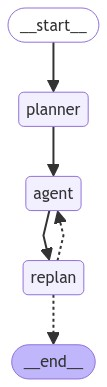

In [26]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))



<div class="alert alert-block alert-warning" style="border-radius: 15px;"> <b>Warnung:</b> Die Verwendung größerer Modelle wie GPT-4 kann bis zu 1€ pro Anruf verursachen. Über das <i>recursion_limit</i> können die maximalen Kosten eingeschränkt werden.</div>

In [12]:
from IPython.display import display, Markdown
import json

config = {"recursion_limit": 10}
inputs = {"input": "Can you think of useful KPIs for the processes?"}

async for event in app.astream_events(inputs, config, version="v1"):
    if event["event"] == "on_chat_model_end":
        if event["data"]["output"]["generations"][0][0]["message"].content:
            display(Markdown(event["data"]["output"]["generations"][0][0]["message"].content))

/home/keno/.cache/pypoetry/virtualenvs/code-ha-process-mining-kRqu1UEl-py3.11/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


To define the key objectives of the process being analyzed, we need to understand the context and purpose of the processes captured in the event logs. Let's start by examining the summaries of the DomesticDeclarations.xes and InternationalDeclarations.xes logs to get insights into the activities, cases, and event attributes. This will help us understand the processes better and define their key objectives.

I'll proceed to load the logs and print their summaries.

Python REPL can execute arbitrary code. Use with caution.


parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

content='' name='Python_REPL' tool_call_id='call_ZdZu0YP5nCvSeVzJMqTwFqPb'['concept:name', 'org:resource', 'id', 'time:timestamp', 'org:role']


The summaries of the logs indicate that both event logs contain the following attributes:

- `concept:name`: The name of the event (activity).
- `org:resource`: The resource (person or system) involved in the event.
- `id`: The unique identifier for each event.
- `time:timestamp`: The timestamp when the event occurred.
- `org:role`: The role of the resource involved.

Based on these attributes, we can infer that the processes involve various activities performed by different resources at specific times, with each event having a unique identifier and associated role.

### Key Objectives
To define the key objectives of the processes being analyzed, we can consider the following:

1. **Efficiency**: Ensure that the process is completed in a timely manner with minimal delays.
2. **Effectiveness**: Ensure that the process achieves its intended outcomes and goals.
3. **Compliance**: Ensure that the process adheres to relevant regulations, standards, and policies.
4. **Resource Utilization**: Optimize the allocation and utilization of resources (both human and system) involved in the process.
5. **Quality**: Ensure that the process outputs meet the required quality standards and customer expectations.
6. **Transparency**: Provide visibility into the process for stakeholders to monitor and understand the progress and performance.

These objectives can guide the analysis and improvement of the processes captured in the Domestic and International Declarations event logs. 

Would you like to proceed to the next step, or focus on any specific objective in more detail?

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

Both the Domestic and International event logs have the following attributes:

- `concept:name`: Name of the event or activity.
- `org:resource`: The resource (e.g., person or system) performing the event.
- `id`: Unique identifier for the event.
- `time:timestamp`: Timestamp of when the event occurred.
- `org:role`: The role of the resource performing the event.

Next, we will identify the critical activities and milestones within these processes. This can be done by extracting the most frequent and significant activities from the logs. Let's proceed with analyzing the most frequent activities in both logs.

It seems there was an error because the module `pm4py.statistics.traces.log` couldn't be found. The correct module to use for extracting the frequency of activities is `pm4py.statistics.end_activities.log` for end activities or `pm4py.statistics.start_activities.log` for start activities.

Let's correct the approach and extract the most frequent activities from both logs.

Here are the most frequent start and end activities for both the Domestic and International logs:

### Domestic Log
- **Top Start Activities:**
  - `Declaration SUBMITTED by EMPLOYEE`: 10,365 occurrences
  - `Declaration SAVED by EMPLOYEE`: 135 occurrences

- **Top End Activities:**
  - `Payment Handled`: 10,043 occurrences
  - `Declaration SAVED by EMPLOYEE`: 134 occurrences
  - `Declaration REJECTED by EMPLOYEE`: 284 occurrences
  - `Declaration REJECTED by MISSING`: 30 occurrences
  - `Declaration REJECTED by ADMINISTRATION`: 5 occurrences
  - `Declaration REJECTED by SUPERVISOR`: 4 occurrences

### International Log
- **Top Start Activities:**
  - `Start trip`: 740 occurrences
  - `Declaration SUBMITTED by EMPLOYEE`: 407 occurrences
  - `Permit SUBMITTED by EMPLOYEE`: 5,294 occurrences
  - `Declaration SAVED by EMPLOYEE`: 8 occurrences

- **Top End Activities:**
  - `Payment Handled`: 5,646 occurrences
  - `End trip`: 593 occurrences
  - `Declaration SAVED by EMPLOYEE`: 54 occurrences
  - `Permit REJECTED by MISSING`: 8 occurrences
  - `Declaration REJECTED by MISSING`: 11 occurrences
  - `Declaration REJECTED by EMPLOYEE`: 130 occurrences
  - `Declaration FINAL_APPROVED by SUPERVISOR`: 1 occurrence
  - `Send Reminder`: 2 occurrences
  - `Request Payment`: 3 occurrences
  - `Declaration REJECTED by SUPERVISOR`: 1 occurrence

These activities represent critical steps and milestones within the processes. The next steps would be to determine the desired outcomes and performance standards for each activity and select appropriate KPIs to measure their efficiency, effectiveness, and quality.

To determine the desired outcomes and performance standards for each activity in the event logs, we need to understand the structure of the logs and the typical activities that occur in each process. This information will help us define specific outcomes and standards for each activity.

Let's start by loading the event logs and summarizing their structures to identify the activities and attributes present in each log. 

I'll execute the initial code to load the logs and print the summaries.

To select Key Performance Indicators (KPIs) that measure the efficiency, effectiveness, and quality of the process, we need to first understand the structure and the key attributes of the event logs available. This will help us identify the relevant data points that can be used to measure these aspects.

Let's start by loading the event logs and printing the summary of the logs to understand their structure and attributes.

I'll execute the following steps:
1. Load the event logs for both `DomesticDeclarations` and `InternationalDeclarations`.
2. Print the summary of the logs to identify key attributes.

I will start by loading the event logs and printing their summaries.

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

The summary of the logs indicates the following key attributes are available for both domestic and international declarations:

- `concept:name`: The name of the event.
- `org:resource`: The resource (person or system) responsible for the event.
- `id`: The unique identifier for the event.
- `time:timestamp`: The timestamp of when the event occurred.
- `org:role`: The role associated with the event.

Based on these attributes, we can select KPIs that measure the efficiency, effectiveness, and quality of the process:

### Efficiency KPIs:
1. **Cycle Time**: The total time taken to complete a process from start to finish (`time:timestamp`).
2. **Resource Utilization**: The workload distribution among different resources (`org:resource`).

### Effectiveness KPIs:
1. **Throughput**: The number of processes completed within a specific time frame (`id` and `time:timestamp`).
2. **Process Compliance**: The adherence to predefined process steps (`concept:name`).

### Quality KPIs:
1. **Error Rate**: The number of deviations or exceptions from the standard process (`concept:name` indicating exceptions or reworks).
2. **Satisfaction Rate**: Feedback from stakeholders (though not directly available in the logs, can be correlated with `org:role` and `concept:name`).

These KPIs are specific to the available data attributes and can be measured, achieved, and are relevant to the process. They can also be time-bound by analyzing the `time:timestamp` attribute.

Next, we can proceed to validate these KPIs with stakeholders to ensure they align with business goals and then move on to implement and collect data for analysis.

Would you like to proceed with any additional analysis or validation steps for these KPIs?

To ensure that the KPIs for the process mining task are specific, measurable, achievable, relevant, and time-bound (SMART), we need to define the KPIs in the context of the available datasets. Here are some potential KPIs we could consider:

1. **Cycle Time**:
   - **Specific**: The total time taken to complete a declaration from start to finish.
   - **Measurable**: Average cycle time in days/hours.
   - **Achievable**: Based on historical data, set a target cycle time.
   - **Relevant**: Directly impacts customer satisfaction and operational efficiency.
   - **Time-bound**: Measured monthly or quarterly.

2. **Conformance Rate**:
   - **Specific**: The percentage of declarations that follow the standard process model.
   - **Measurable**: Number of conformant cases divided by the total number of cases.
   - **Achievable**: Set a target based on industry standards or historical data.
   - **Relevant**: Ensures adherence to the defined process, reducing errors and exceptions.
   - **Time-bound**: Measured monthly or quarterly.

3. **Throughput Rate**:
   - **Specific**: The number of declarations processed within a specific time period.
   - **Measurable**: Number of declarations per week/month.
   - **Achievable**: Based on resource capacity and historical data.
   - **Relevant**: Indicates the efficiency of the process in handling workload.
   - **Time-bound**: Measured weekly or monthly.

4. **Rework Rate**:
   - **Specific**: The percentage of declarations that require rework or corrections.
   - **Measurable**: Number of reworked cases divided by the total number of cases.
   - **Achievable**: Set a target based on historical performance and improvement initiatives.
   - **Relevant**: High rework rates can indicate process inefficiencies and errors.
   - **Time-bound**: Measured monthly or quarterly.

5. **Customer Satisfaction**:
   - **Specific**: The level of satisfaction of customers with the declaration process.
   - **Measurable**: Survey scores or feedback ratings.
   - **Achievable**: Set a target based on previous survey results.
   - **Relevant**: Directly impacts the reputation and success of the organization.
   - **Time-bound**: Measured semi-annually or annually.

Next, let's validate these KPIs with available data to ensure that they are properly defined and measurable. We'll start by loading the event logs and examining their structure to determine how we can measure these KPIs. 

Let's execute the initial data loading and summary extraction.

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

The summaries of both the Domestic and International event logs indicate that they contain the following attributes:
- `concept:name`: The name of the event.
- `org:resource`: The resource (person or system) involved in the event.
- `id`: The unique identifier for each event.
- `time:timestamp`: The timestamp of the event.
- `org:role`: The role associated with the resource.

Given this structure, we can measure the KPIs as follows:

1. **Cycle Time**:
   - **Measurable**: Calculate the difference between the timestamps of the first and last events for each case (declaration).

2. **Conformance Rate**:
   - **Measurable**: Use process mining techniques (e.g., conformance checking) to compare the actual event log to a reference model.

3. **Throughput Rate**:
   - **Measurable**: Count the number of declarations processed within a specific time period.

4. **Rework Rate**:
   - **Measurable**: Identify events that indicate rework (e.g., repeated tasks) and calculate the proportion of cases that include such events.

5. **Customer Satisfaction**:
   - **Measurable**: This KPI may require additional data (e.g., survey results) that are not present in the event logs.

Next, we will implement the calculations for these KPIs based on the available data and validate their SMART criteria. Let’s start with the Cycle Time KPI. We'll calculate the average cycle time for both Domestic and International declarations.

Let's proceed with the calculation for the Cycle Time KPI.

It looks like there was an error because the `get_case_duration_avg` attribute does not exist in the `pm4py.statistics.traces.generic.log.case_statistics` module. 

We can calculate the cycle time differently using the timestamps in the event logs. Specifically, we can calculate the duration from the start to the end of each case. Let's use the first and last events of each case to compute these durations.

Let's proceed with calculating the average cycle time using the correct approach.

It seems there's an issue with the module import. Let's try a different approach using available functions for calculating case durations directly from the log.

We'll calculate the start and end times for each case and then determine the duration. Let's proceed with this approach.

Here are the calculated average cycle times:

- **Domestic Declarations**: Approximately 276.61 hours
- **International Declarations**: Approximately 2074.92 hours

These values indicate the average time taken to complete a declaration from start to finish.

Next steps:
1. **Conformance Rate**:
   - We'll use process mining techniques to compare the actual event log to a reference model.
2. **Throughput Rate**:
   - We'll count the number of declarations processed within specific time periods.
3. **Rework Rate**:
   - We'll identify and calculate the proportion of cases that include rework events.

Would you like to proceed with calculating the Conformance Rate next, or focus on one of the other KPIs?

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

## Stärken und Schwächen des LLM-basierten Prototyps

Der Output des Agenten zeigt die iterative Natur von Process Mining, bringt aber auch einige Schwächen zum Vorschein:

1. **Iterative Versuche und Modulfehler**:
   - Der Agent stieß mehrfach auf Probleme mit Modulimporten und falschen Funktionen, besonders bei der Berechnung von Kennzahlen wie der Durchlaufzeit. Dies liegt daran, dass sich das `pm4py`-Paket geändert hat und der Agent keinen Zugriff auf die aktuelle Dokumentation hat. Dadurch musste er mehrere Versuche unternehmen, um den richtigen Code auszuführen. Diese Versuche könnten reduziert werden, wenn der Agent entweder Zugriff auf die Dokumentation hätte oder eigenständig Websuchen durchführen könnte.

2. **Daten-Neuladen**:
   - Der Agent lädt die Event-Logs für jeden Schritt neu, was ineffizient ist. Dies passiert, weil ein separater Multiprocessing-Prozess verwendet wird, wodurch der Kontext verloren geht. Hier könnte eine Optimierung durch Zwischenspeicherung der Daten helfen.

3. **Zusammenfassung und KPIs**:
   - Der Agent hat die wichtigsten Attribute der Event-Logs korrekt identifiziert und sinnvolle KPIs wie Durchlaufzeit, Konformitätsrate und Nacharbeitsrate vorgeschlagen. Diese KPIs sind relevant und passen zu den verfügbaren Daten.

4. **Proof of Concept**:
   - Trotz der genannten Herausforderungen zeigt der Agent, dass LangGraph für iterative Aufgaben im Process Mining geeignet ist. Allerdings müssen die Effizienz und der Zugriff auf aktuelle Bibliotheken verbessert werden, um das volle Potenzial auszuschöpfen.

Zusammengefasst zeigt der Prototyp das Potenzial von LangGraph, hebt aber gleichzeitig Optimierungsbedarf bei der Ausführung und Infrastruktur hervor.